# Load dataset

In [53]:
import pandas as pd
import altair as alt
from IPython.display import Image

In [59]:
train_X = pd.read_csv('../Dataset/train_X.csv')
train_y = pd.read_csv('../Dataset/train_y.csv')
test_X = pd.read_csv('../Dataset/test_X.csv')
test_y = pd.read_csv('../Dataset/test_y.csv')

In [60]:
train_X.shape, train_y.shape

((15095, 180), (15095, 1))

# Load base model
candidates:
- Decision tree
- Randomforest
- Support vector machine

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [57]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay

# Baseline

Set baseline by random guessing.  
Precision, Recall => 0.5  
AUC => 0.5

## Decision Tree

In [65]:
train_X = train_X[[c for c in train_X.columns if c not in ['user_id']]]
test_X = test_X[[c for c in test_X.columns if c not in ['user_id']]]

In [66]:
decision_tree_base = DecisionTreeClassifier(random_state=42)
decision_tree_base.fit(train_X, train_y)
pred_y = decision_tree_base.predict(test_X)

In [67]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,2400,1009
True positive,950,3076


In [18]:
def get_score(test_y, pred_y):
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    return round(precision,2), round(recall,2), round(f1,2)

In [68]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base decision tree: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base decision tree: precision=0.75, recall=0.76, f1=0.76


In [69]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)

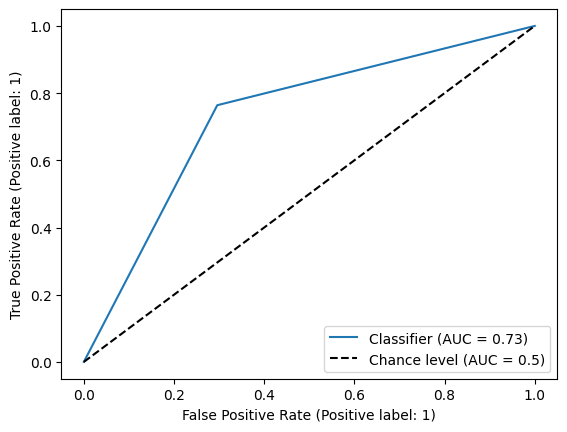

In [70]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)
# roc_display.figure_.savefig("decision_base_roc_curve.png")
# Image("decision_base_roc_curve.png")

## RandomForest

In [71]:
random_forest_base = RandomForestClassifier(random_state=42)
random_forest_base.fit(train_X, train_y)
pred_y = random_forest_base.predict(test_X)

C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [72]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,2412,997
True positive,945,3081


In [73]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base random forest: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base random forest: precision=0.76, recall=0.77, f1=0.76


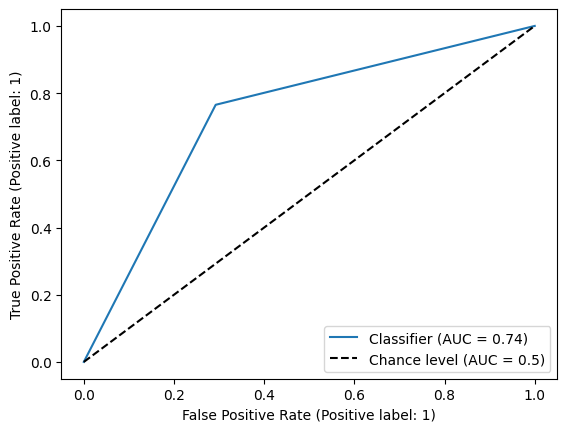

In [74]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)

## SVM

In [75]:
svc_base = SVC(random_state=42)
svc_base.fit(train_X, train_y)
pred_y = svc_base.predict(test_X)

C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,3000,409
True positive,1662,2364


In [76]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base SVC: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base SVC: precision=0.93, recall=0.56, f1=0.7


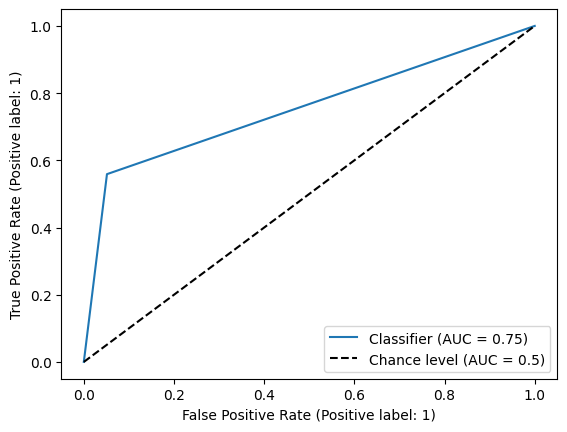

In [77]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)

# Model selection
As we see in EDA, False negative costs more than False positive, therefore Recall socre should be high.  
According to above base model case review, RandomForest model shows the highest recall score and a little bit higher AUC.  
I'll tune decision tree model to get the best score.  

In [79]:
from sklearn.model_selection import GridSearchCV

In [82]:
train_X.shape

(15095, 179)

In [83]:
param_grid = {
    'n_estimators': [10, 50, 100, 150, 170],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 170]},
             verbose=2)

In [84]:
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [85]:
random_forest = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=10, n_estimators=100)
random_forest.fit(train_X, train_y)
pred_y = random_forest.predict(test_X)

C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [86]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,3223,186
True positive,1307,2719


In [87]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base random forest: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base random forest: precision=0.94, recall=0.68, f1=0.78


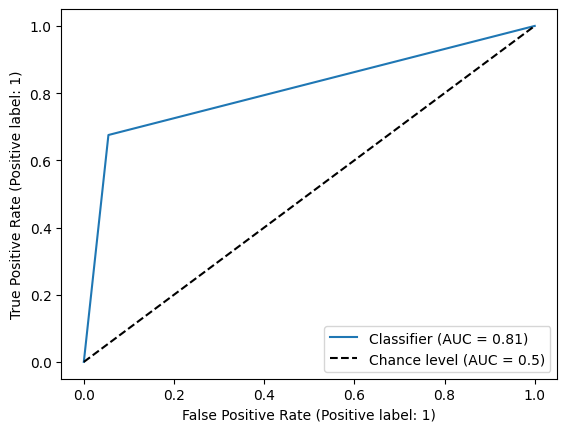

In [88]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)